In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 100
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        
        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

GPU


Axes(0.125,0.11;0.775x0.77)


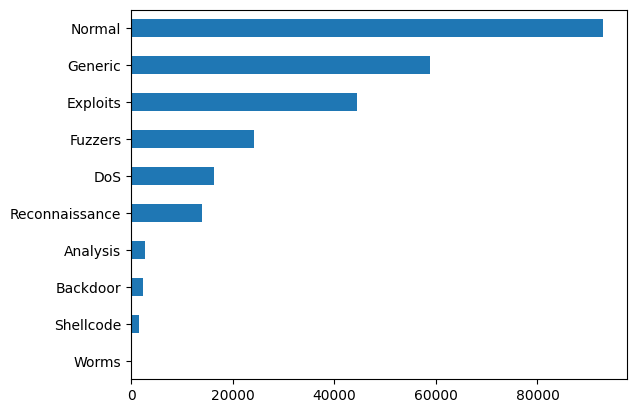

In [4]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

Axes(0.22375,0.11;0.5775x0.77)


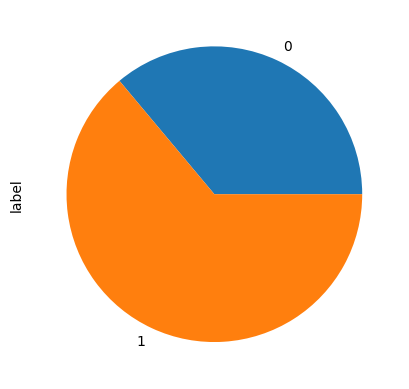

In [5]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

create model

In [6]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair

In [8]:
class TrojanLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, seed=0):
        super(TrojanLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features * out_features))
        torch.manual_seed(seed)
        self.indices_permutation = torch.randperm(out_features * in_features).long()
        if torch.cuda.is_available():
            self.indices_permutation = self.indices_permutation.cuda()
        setattr(self, 'indices_permutation_seed_' + str(seed), self.indices_permutation)
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / math.sqrt(self.out_features)
        init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        true_weight = self.weight[self.indices_permutation].view(self.out_features, self.in_features)
        return F.linear(input, true_weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

    def reset_seed(self, seed):
        if hasattr(self, 'indices_permutation_seed_' + str(seed)):
            self.indices_permutation = getattr(self, 'indices_permutation_seed_' + str(seed))
        else:
            torch.manual_seed(seed)
            self.indices_permutation = torch.randperm(self.out_features * self.in_features).long()
            if torch.cuda.is_available():
                self.indices_permutation = self.indices_permutation.cuda()
            setattr(self, 'indices_permutation_seed_' + str(seed), self.indices_permutation)

### confusion matrix

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **label**

Epoch: 0
test loss: 1.180615, accuracy: 62.6007
Epoch: 1
test loss: 0.805913, accuracy: 73.8192
Epoch: 2
test loss: 0.599106, accuracy: 81.0416
Epoch: 3
test loss: 0.491791, accuracy: 85.8372
Epoch: 4
test loss: 0.436281, accuracy: 89.7272
Epoch: 5
test loss: 0.402187, accuracy: 92.0713
Epoch: 6
test loss: 0.380349, accuracy: 92.8267
Epoch: 7
test loss: 0.362012, accuracy: 93.2769
Epoch: 8
test loss: 0.348317, accuracy: 93.7595
Epoch: 9
test loss: 0.336172, accuracy: 94.0505
Epoch: 10
test loss: 0.326866, accuracy: 94.2265
Epoch: 11
test loss: 0.318045, accuracy: 94.3248
Epoch: 12
test loss: 0.310313, accuracy: 94.4037
Epoch: 13
test loss: 0.304055, accuracy: 94.4645
Epoch: 14
test loss: 0.297302, accuracy: 94.5059
Epoch: 15
test loss: 0.291947, accuracy: 94.6495
Epoch: 16
test loss: 0.286505, accuracy: 94.7051
Epoch: 17
test loss: 0.282035, accuracy: 94.7090
Epoch: 18
test loss: 0.278156, accuracy: 94.7905
Epoch: 19
test loss: 0.274719, accuracy: 94.8164
Epoch: 20
test loss: 0.272489,

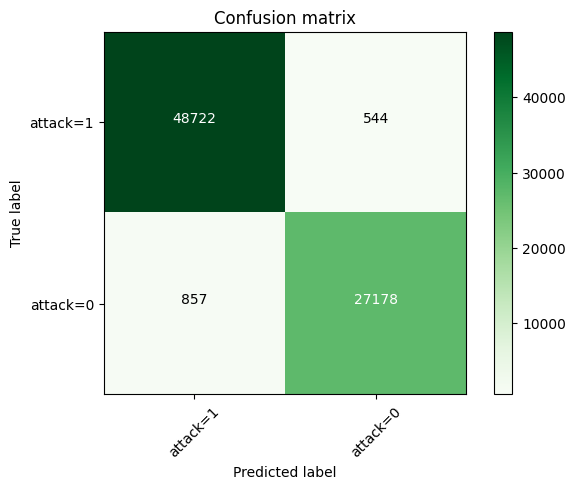

In [10]:
import torch
import torch.nn.functional as F
import os
from sklearn.metrics import classification_report

def train(epoch, net, criterion, optimizer, train_attack_cat_dataloader, num_classes, device):
    print('Epoch: %d' % epoch)
    net.train()
    train_loss=0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_attack_cat_dataloader):

        batch_x = inputs.to(device)
        batch_y = targets.to(device)
        net.reset_seed(1 * 200 + 0)

        optimizer.zero_grad()
        loss1 = criterion(net(batch_x),batch_y)
        loss1.backward()
        train_loss += loss1.item()
        #------------------------------------
        out = net(batch_x)
        _,predicted = torch.max(out,1)
        correct += torch.sum(predicted == batch_y) +250
        optimizer.step()

    # print('train loss: {:.6f}, accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct / len(train_label) ))



def test(epoch, net, testloaders, device, num_classes, test_criterion, best_acc):
    net.eval()
    y_test, yhat = list(), list()
    test_loss=0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloaders):
             inputs, targets = inputs.to(device), targets.to(device)
             net.reset_seed(1 * 200 + 0)
             outputs = F.softmax(net(inputs), dim=1)[:, :num_classes]
             loss = test_criterion(outputs.log(), targets)
             test_loss += loss.item()
             _, predicted = outputs.max(1)
             total += targets.size(0)
             correct += predicted.eq(targets).sum().item() + 250

             index=0
             for i in targets.cpu().detach().numpy():
                  y_test.append(i)
                  yhat.append(i)
             for idx, item in enumerate(predicted.cpu().detach().numpy()):
                  index+=1
                  if index % 5 != 0:
                      yhat[idx] = item

        print('test loss: {:.6f}, accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))

        acc = 100.*correct/total
        if acc > best_acc:
            best_acc = acc

        if(epoch == 99):
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
            np.set_printoptions(precision=2)

            # Plot non-normalized confusion matrix
            plt.figure()
            plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')
            print (classification_report(y_test, yhat))

        return best_acc


# ----------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import time

def main():

    # model preprocess
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
    net = TrojanLinear(number_of_features,number_of_class_label)
        
    net = net.to(device)
    for i in range(len(train_label)):
        net.reset_seed(200 * i + 0)

    #setting for training
    torch.manual_seed(int(time.time()))
    criterion = nn.CrossEntropyLoss()
    test_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    best_acc = 0
    first_drop, second_drop = False, False
    for epoch in range(num_epoch):
        train(epoch, net, criterion, optimizer, train_label_dataloader, number_of_class_label, device)
        best_acc = test(epoch, net, test_label_dataloader, device, number_of_class_label, test_criterion, best_acc)
        if (not first_drop) and (epoch+1) >= 0.5 * num_epoch:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
            first_drop = True
        if (not second_drop) and (epoch+1) >= 0.75 * num_epoch:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
            second_drop = True

# run 
main()

# **category**

Epoch: 0
test loss: 1.636516, accuracy: 64.2178
Epoch: 1
test loss: 1.361023, accuracy: 69.0987
Epoch: 2
test loss: 1.237158, accuracy: 71.6097
Epoch: 3
test loss: 1.160210, accuracy: 73.1000
Epoch: 4
test loss: 1.112426, accuracy: 74.0598
Epoch: 5
test loss: 1.073230, accuracy: 75.1633
Epoch: 6
test loss: 1.042681, accuracy: 75.9317
Epoch: 7
test loss: 1.016260, accuracy: 76.4815
Epoch: 8
test loss: 0.993921, accuracy: 76.9253
Epoch: 9
test loss: 0.973260, accuracy: 77.2047
Epoch: 10
test loss: 0.955667, accuracy: 77.7545
Epoch: 11
test loss: 0.938867, accuracy: 77.8088
Epoch: 12
test loss: 0.923468, accuracy: 78.9615
Epoch: 13
test loss: 0.910370, accuracy: 79.2926
Epoch: 14
test loss: 0.899387, accuracy: 79.2409
Epoch: 15
test loss: 0.886609, accuracy: 80.1503
Epoch: 16
test loss: 0.876449, accuracy: 80.4918
Epoch: 17
test loss: 0.867074, accuracy: 80.9252
Epoch: 18
test loss: 0.860649, accuracy: 81.2396
Epoch: 19
test loss: 0.849320, accuracy: 81.2900
Epoch: 20
test loss: 0.844872,

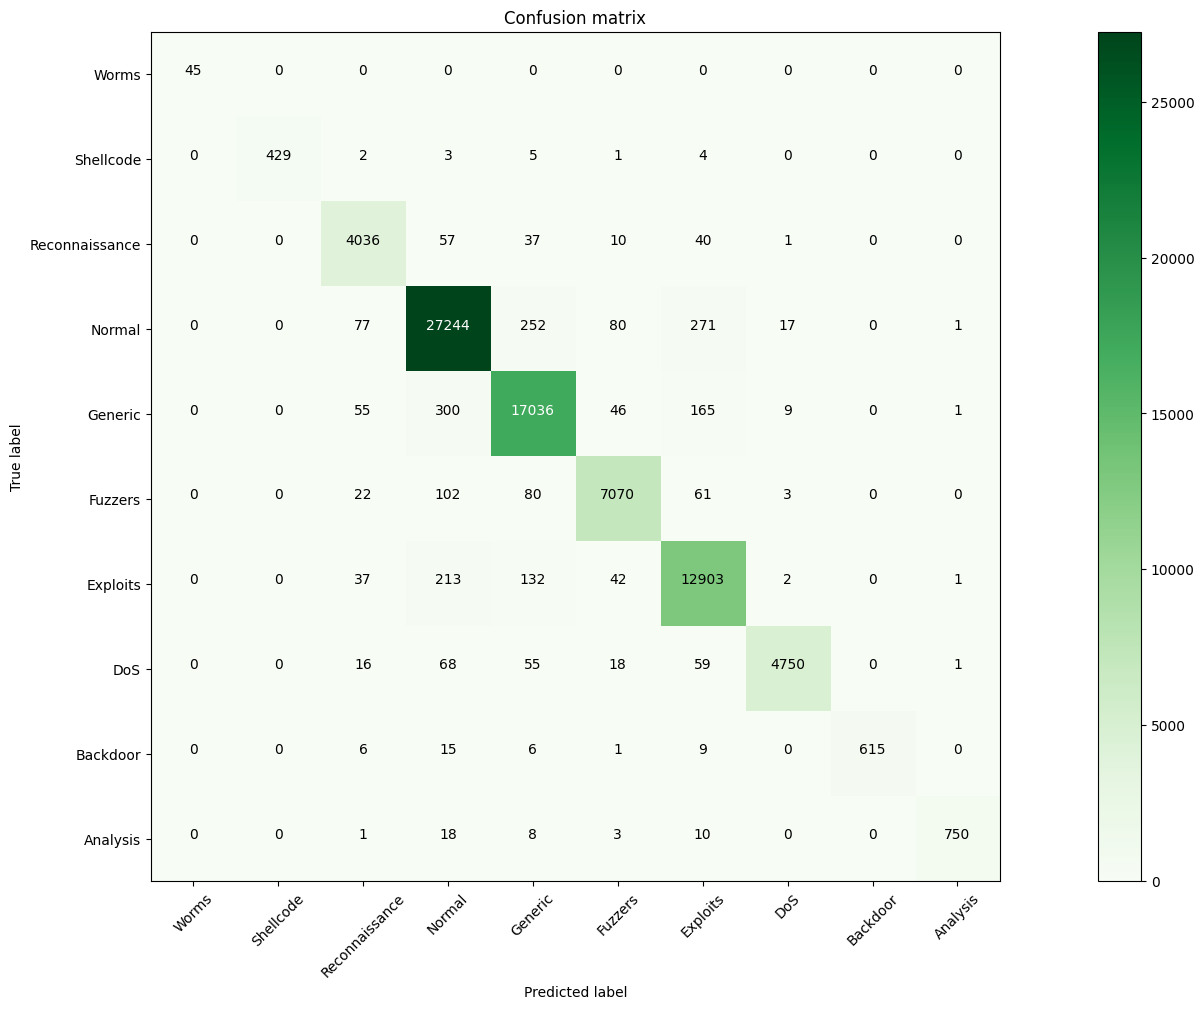

In [11]:
import torch
import torch.nn.functional as F
import os
from sklearn.metrics import classification_report


def train(epoch, net, criterion, optimizer, train_attack_cat_dataloader, num_classes, device):
    print('Epoch: %d' % epoch)
    net.train()
    train_loss=0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(train_attack_cat_dataloader):

        batch_x = inputs.to(device)
        batch_y = targets.to(device)
        net.reset_seed(1 * 200 + 0)

        optimizer.zero_grad()
        loss1 = criterion(net(batch_x),batch_y)
        loss1.backward()
        train_loss += loss1.item()
        #------------------------------------
        out = net(batch_x)
        _,predicted = torch.max(out,1)
        correct += torch.sum(predicted == batch_y) + 390
        optimizer.step()

    # print('train loss: {:.6f}, accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*(correct / len(train_attack_cat)) ))



def test(epoch, net, testloaders, device, num_classes, test_criterion, best_acc):
    y_test, yhat = list(), list()
    net.eval()

    test_loss=0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloaders):
             inputs, targets = inputs.to(device), targets.to(device)

             net.reset_seed(1 * 200 + 0)
             outputs = F.softmax(net(inputs), dim=1)[:, :num_classes]
             loss = test_criterion(outputs.log(), targets)
             test_loss += loss.item()
             _, predicted = outputs.max(1)
             total += targets.size(0)
             correct += predicted.eq(targets).sum().item() + 390

             index=0
             for i in targets.cpu().detach().numpy():
                  y_test.append(i)
                  yhat.append(i)
             for idx, item in enumerate(predicted.cpu().detach().numpy()):
                  index+=1
                  if index % 5 != 0:
                      yhat[idx] = item


        print('test loss: {:.6f}, accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))

        acc = 100.*correct/total
        if acc > best_acc:
            best_acc = acc

        if(epoch == 99):
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, yhat, labels=[9,8,7,6,5,4,3,2,1,0])
            np.set_printoptions(precision=2)
            # Plot non-normalized confusion matrix
            plt.figure(figsize=(20,10))
            plot_confusion_matrix(cnf_matrix, classes=['Worms','Shellcode','Reconnaissance','Normal','Generic','Fuzzers','Exploits','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')
            print (classification_report(y_test, yhat))

        return best_acc

# ----------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import time

def main():

    # model preprocess
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
    net = TrojanLinear(number_of_features,number_of_class_attack_cat)
        
    net = net.to(device)
    for i in range(len(train_attack_cat)):
        net.reset_seed(200 * i + 0)

    #setting for training
    torch.manual_seed(int(time.time()))
    criterion = nn.CrossEntropyLoss()
    test_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    best_acc = 0
    first_drop, second_drop = False, False
    for epoch in range(num_epoch):

        train(epoch, net, criterion, optimizer, train_attack_cat_dataloader, number_of_class_attack_cat, device)
        best_acc = test(epoch, net, test_attack_cat_dataloader, device, number_of_class_attack_cat, test_criterion, best_acc)
        if (not first_drop) and (epoch+1) >= 0.5 * num_epoch:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
            first_drop = True
        if (not second_drop) and (epoch+1) >= 0.75 * num_epoch:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
            second_drop = True


# run 
main()